# Predict 1-year revenue

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import seaborn as sns
import pylab as pl
sns.set_context(context='talk')

In [2]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn import utils
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold, LeaveOneGroupOut, RandomizedSearchCV

## Obtaining the data

In [3]:
data = pd.read_csv('daily_cohorts_processed.csv')

In [4]:
data.head()

,platform,campaign_date,activity_date,installs,active_players,agg_purchases,cum_purchases,agg_payers,agg_new_payers,agg_ads,...,cum_purchases_3,cum_new_payers_3,cum_iap_net_revenue_3,cum_ad_net_revenue_3,cum_revenue_7,cum_purchases_7,cum_new_payers_7,cum_iap_net_revenue_7,cum_ad_net_revenue_7,CVgroup
0,android,2019-02-22,2019-02-23,1330,786,1,4,1,1,4402,...,5,4,14.292776,9.260668,27.937257,5.0,4.0,14.292776,13.644481,0
1,android,2019-02-22,2019-02-24,1330,477,1,5,1,1,3150,...,5,4,14.292776,9.260668,27.937257,5.0,4.0,14.292776,13.644481,0
2,android,2019-02-22,2019-03-16,1330,152,1,6,1,1,797,...,5,4,14.292776,9.260668,27.937257,5.0,4.0,14.292776,13.644481,0
3,android,2019-02-23,2019-03-11,2429,381,1,1,1,1,2216,...,0,0,0.000000,20.783164,29.914896,0.0,0.0,0.000000,29.914896,4
4,android,2019-02-23,2019-03-13,2429,383,1,2,1,1,2009,...,0,0,0.000000,20.783164,29.914896,0.0,0.0,0.000000,29.914896,4


## Calculating some derived parameters

'cum_purchases', 'cum_new_payers', 'cum_iap_net_revenue', 'cum_ad_net_revenue'
at 1, 3 and 7 days after the start of the cohort.

In [5]:
first_date = pd.to_datetime(data['campaign_date']).min()

In [6]:
def process_data(raw_data):
    data = raw_data.copy()
    
    data['cohort'] = pd.to_datetime(data['campaign_date'])
    data['cohort_day'] = (data['cohort'] - first_date).dt.days
    
    data['installs'] = data['installs'].astype(int)
    
    return data

Obtain the cohorts that have a full year of data available in the training set. For these, keep the features we want to experiment with.

In [7]:
features = ['spend', 'spend_bins', 'installs', 'cum_revenue',
'cum_revenue_3', 'cum_purchases_3', 'cum_new_payers_3', 'cum_iap_net_revenue_3', 'cum_ad_net_revenue_3',
'cum_revenue_7', 'cum_purchases_7', 'cum_new_payers_7', 'cum_iap_net_revenue_7', 'cum_ad_net_revenue_7']

In [8]:
full_cohorts = data[data['day'] == 364].groupby(['campaign_date', 'platform'])[features].first()
full_cohorts.reset_index(inplace=True)
full_cohorts = process_data(full_cohorts)

In [9]:
full_cohorts

,campaign_date,platform,spend,spend_bins,installs,cum_revenue,cum_revenue_3,cum_purchases_3,cum_new_payers_3,cum_iap_net_revenue_3,cum_ad_net_revenue_3,cum_revenue_7,cum_purchases_7,cum_new_payers_7,cum_iap_net_revenue_7,cum_ad_net_revenue_7,cohort,cohort_day
0,2019-02-22,android,76.804863,<1k,1330,108.914130,23.553444,5,4,14.292776,9.260668,27.937257,5.0,4.0,14.292776,13.644481,2019-02-22,0
1,2019-02-22,ios,77.927675,<1k,480,73.995566,12.320956,1,1,2.919819,9.401137,17.559060,1.0,1.0,2.919819,14.639241,2019-02-22,0
2,2019-02-23,android,82.940633,<1k,2429,198.599408,20.783164,0,0,0.000000,20.783164,29.914896,0.0,0.0,0.000000,29.914896,2019-02-23,1
3,2019-02-23,ios,82.781851,<1k,725,167.224575,15.250162,0,0,0.000000,15.250162,24.047354,0.0,0.0,0.000000,24.047354,2019-02-23,1
4,2019-02-24,android,83.135325,<1k,2780,267.194414,28.986688,4,4,5.341061,23.645627,39.771222,5.0,5.0,5.527206,34.244016,2019-02-24,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,2019-04-28,ios,448.047097,<1k,275,338.160518,46.231506,4,4,27.785862,18.445644,79.385133,8.0,7.0,47.058990,32.326143,2019-04-28,65
102,2019-04-29,android,1419.904704,1-2k,1065,4265.742197,323.892970,70,60,288.207326,35.685644,677.345570,104.0,87.0,618.298750,59.046820,2019-04-29,66
103,2019-04-29,ios,447.095273,<1k,229,362.267739,63.317301,9,9,49.426377,13.890924,93.933365,13.0,12.0,69.537549,24.395816,2019-04-29,66
104,2019-04-30,android,1546.608554,1-2k,1436,1626.693337,285.737514,56,43,241.905939,43.831575,486.936422,80.0,62.0,415.470533,71.465889,2019-04-30,67


# Some fast data analysis
This is mainly for the figures that are included in the summary

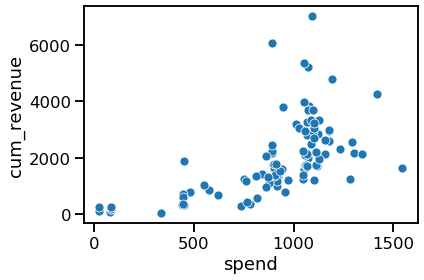

In [10]:
sns.scatterplot('spend', 'cum_revenue', data=full_cohorts)
pl.tight_layout()
pl.savefig('ltrplots/cum_revenue_vs_spend.png')

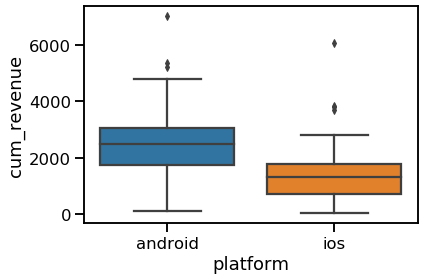

In [11]:
sns.boxplot('platform', 'cum_revenue', data=full_cohorts)
pl.tight_layout()
pl.savefig('ltrplots/cum_revenue_vs_platform.png')

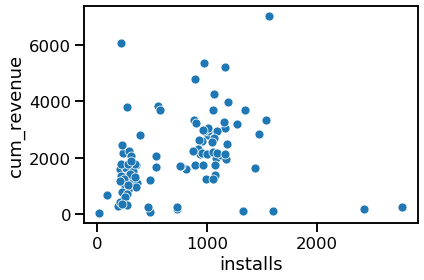

In [12]:
sns.scatterplot('installs', 'cum_revenue', data=full_cohorts)
pl.tight_layout()
pl.savefig('ltrplots/cum_revenue_vs_installs.png')

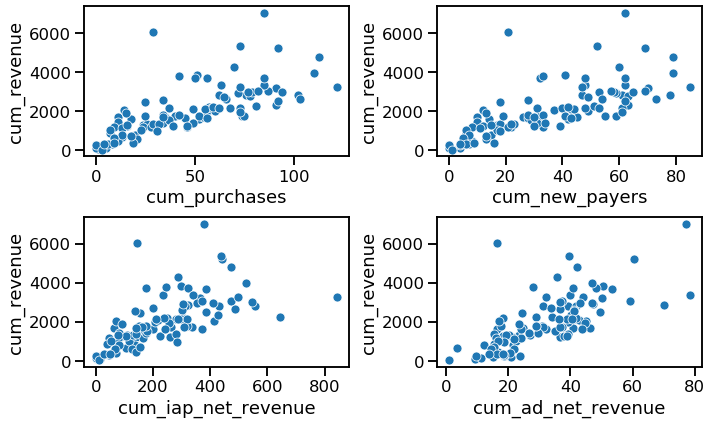

In [13]:
pl.figure(figsize=(10,6))

pl.subplot(221)
sns.scatterplot('cum_purchases_3', 'cum_revenue', data=full_cohorts)
pl.xlabel('cum_purchases')

pl.subplot(222)
sns.scatterplot('cum_new_payers_3', 'cum_revenue', data=full_cohorts)
pl.xlabel('cum_new_payers')

pl.subplot(223)
sns.scatterplot('cum_iap_net_revenue_3', 'cum_revenue', data=full_cohorts)
pl.xlabel('cum_iap_net_revenue')

pl.subplot(224)
sns.scatterplot('cum_ad_net_revenue_3', 'cum_revenue', data=full_cohorts)
pl.xlabel('cum_ad_net_revenue')

pl.tight_layout()
pl.savefig('ltrplots/cum_features_after_3_days.png')

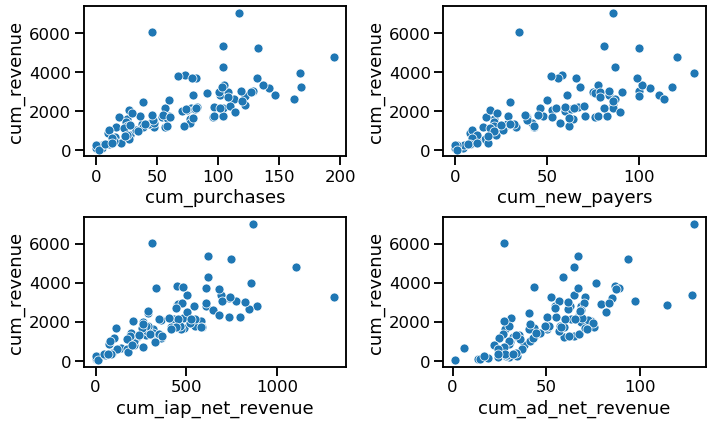

In [14]:
pl.figure(figsize=(10,6))

pl.subplot(221)
sns.scatterplot('cum_purchases_7', 'cum_revenue', data=full_cohorts)
pl.xlabel('cum_purchases')

pl.subplot(222)
sns.scatterplot('cum_new_payers_7', 'cum_revenue', data=full_cohorts)
pl.xlabel('cum_new_payers')

pl.subplot(223)
sns.scatterplot('cum_iap_net_revenue_7', 'cum_revenue', data=full_cohorts)
pl.xlabel('cum_iap_net_revenue')

pl.subplot(224)
sns.scatterplot('cum_ad_net_revenue_7', 'cum_revenue', data=full_cohorts)
pl.xlabel('cum_ad_net_revenue')

pl.tight_layout()
pl.savefig('ltrplots/cum_features_after_7_days.png')

## Making a model

Make a copy of the data set and convert platform to an integer.

In [15]:
full_cohorts_mod = full_cohorts.copy()

platform_conversion = {'android': 0, 'ios': 1}
full_cohorts_mod['platform'] = full_cohorts['platform'].apply(lambda x: platform_conversion[x])

In [16]:
def mean_absolute_precentage_error(real, pred):
    real = real.values
    s = np.where(real != 0)
    return np.average(np.abs(real[s] - pred[s]) / real[s] * 100)

### Linear Regression

Define the features to use, and split in train and validation set (here called the test set)

In [17]:
X_features = ['cohort_day', 'platform', 'spend', 'installs', 'cum_purchases_3']
y_features = 'cum_revenue'

In [18]:
data_X = full_cohorts_mod[X_features]
data_y = full_cohorts_mod[y_features]
train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.20)

Scale the numerical features. The scaler is setup to experiment easily with different options. 

In [19]:
numeric_features = ['installs', 'spend', 'cum_purchases_3', ]
min_max_features = ['cohort_day']
onehot_features = []
ordinal_features = []

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('minmax', MinMaxScaler(), min_max_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_features),
        ('ordinal', OrdinalEncoder(), ordinal_features),
    ],
    remainder = 'passthrough'
)

train_X_scaled = preprocessor.fit_transform(train_X)
test_X_scaled = preprocessor.transform(test_X)
data_X_scaled = preprocessor.transform(data_X)

The actual modeling and calculation of the scores

In [20]:
lr_model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
lr_model.fit(train_X_scaled, train_y)
print('Mean absolute error:')
print('Training score: ', metrics.mean_absolute_error(train_y, lr_model.predict(train_X_scaled)))
print('Test score: ', metrics.mean_absolute_error(test_y, lr_model.predict(test_X_scaled)))

print('Mean absolute precentage error:')
print('Training score: ', mean_absolute_precentage_error(train_y, lr_model.predict(train_X_scaled)))
print('Test score: ', mean_absolute_precentage_error(test_y, lr_model.predict(test_X_scaled)))

Mean absolute error:
Training score:  545.2825440531905
Test score:  650.3103371449612
Mean absolute precentage error:
Training score:  42.7191401394001
Test score:  128.09027153980904


### Random forest model

Very similar structure for the random forest model

In [21]:
X_features_rf = ['platform', 'spend', 'installs',  'cum_purchases_3', 'cum_iap_net_revenue_7', ]
y_features_rf = 'cum_revenue'

In [22]:
data_X = full_cohorts_mod[X_features_rf]
data_y = full_cohorts_mod[y_features_rf]
train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.20)

In [23]:
rf_model = RandomForestRegressor()

In [24]:
rf_model.fit(train_X, train_y)

RandomForestRegressor()

In [25]:
print('Mean absolute error:')
print('Training score: ', metrics.mean_absolute_error(train_y, rf_model.predict(train_X)))
print('Test score: ', metrics.mean_absolute_error(test_y, rf_model.predict(test_X)))

print('Mean absolute precentage error:')
print('Training score: ', mean_absolute_precentage_error(train_y, rf_model.predict(train_X)))
print('Test score: ', mean_absolute_precentage_error(test_y, rf_model.predict(test_X)))

Mean absolute error:
Training score:  264.37439648522894
Test score:  550.5661277623772
Mean absolute precentage error:
Training score:  20.556207874602713
Test score:  32.99175021196657


#### Grid search CV to find best hyper parameters
To avoid overfitting, we can tune the hyperparameters of the random forest model. We use a grid search with cross validation below.

In [26]:
parameters = {'n_estimators':[25, 50, 75, 100], 'max_depth':[4, 6, 8, 10], 'min_samples_split':[2, 4, 6, 8]}
gs_model = GridSearchCV(rf_model, parameters, verbose=2)
gs_model.fit(data_X, data_y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] max_depth=4, min_samples_split=2, n_estimators=25 ...............
[CV]  max_depth=4, min_samples_split=2, n_estimators=25, total=   0.0s
[CV] max_depth=4, min_samples_split=2, n_estimators=25 ...............
[CV]  max_depth=4, min_samples_split=2, n_estimators=25, total=   0.0s
[CV] max_depth=4, min_samples_split=2, n_estimators=25 ...............
[CV]  max_depth=4, min_samples_split=2, n_estimators=25, total=   0.0s
[CV] max_depth=4, min_samples_split=2, n_estimators=25 ...............
[CV]  max_depth=4, min_samples_split=2, n_estimators=25, total=   0.0s
[CV] max_depth=4, min_samples_split=2, n_estimators=25 ...............
[CV]  max_depth=4, min_samples_split=2, n_estimators=25, total=   0.0s
[CV] max_depth=4, min_samples_split=2, n_estimators=50 ...............
[CV]  max_depth=4, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=4, min_samples_split=2, n_estimators=50 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  max_depth=4, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=4, min_samples_split=2, n_estimators=50 ...............
[CV]  max_depth=4, min_samples_split=2, n_estimators=50, total=   0.0s
[CV] max_depth=4, min_samples_split=2, n_estimators=50 ...............
[CV]  max_depth=4, min_samples_split=2, n_estimators=50, total=   0.0s
[CV] max_depth=4, min_samples_split=2, n_estimators=50 ...............
[CV]  max_depth=4, min_samples_split=2, n_estimators=50, total=   0.0s
[CV] max_depth=4, min_samples_split=2, n_estimators=75 ...............
[CV]  max_depth=4, min_samples_split=2, n_estimators=75, total=   0.1s
[CV] max_depth=4, min_samples_split=2, n_estimators=75 ...............
[CV]  max_depth=4, min_samples_split=2, n_estimators=75, total=   0.1s
[CV] max_depth=4, min_samples_split=2, n_estimators=75 ...............
[CV]  max_depth=4, min_samples_split=2, n_estimators=75, total=   0.1s
[CV] max_depth=4, min_samples_split=2, n_estimators=75 ...............
[CV]  

[CV]  max_depth=4, min_samples_split=8, n_estimators=25, total=   0.0s
[CV] max_depth=4, min_samples_split=8, n_estimators=50 ...............
[CV]  max_depth=4, min_samples_split=8, n_estimators=50, total=   0.1s
[CV] max_depth=4, min_samples_split=8, n_estimators=50 ...............
[CV]  max_depth=4, min_samples_split=8, n_estimators=50, total=   0.0s
[CV] max_depth=4, min_samples_split=8, n_estimators=50 ...............
[CV]  max_depth=4, min_samples_split=8, n_estimators=50, total=   0.0s
[CV] max_depth=4, min_samples_split=8, n_estimators=50 ...............
[CV]  max_depth=4, min_samples_split=8, n_estimators=50, total=   0.0s
[CV] max_depth=4, min_samples_split=8, n_estimators=50 ...............
[CV]  max_depth=4, min_samples_split=8, n_estimators=50, total=   0.1s
[CV] max_depth=4, min_samples_split=8, n_estimators=75 ...............
[CV]  max_depth=4, min_samples_split=8, n_estimators=75, total=   0.1s
[CV] max_depth=4, min_samples_split=8, n_estimators=75 ...............
[CV]  

[CV]  max_depth=6, min_samples_split=6, n_estimators=25, total=   0.0s
[CV] max_depth=6, min_samples_split=6, n_estimators=25 ...............
[CV]  max_depth=6, min_samples_split=6, n_estimators=25, total=   0.0s
[CV] max_depth=6, min_samples_split=6, n_estimators=50 ...............
[CV]  max_depth=6, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] max_depth=6, min_samples_split=6, n_estimators=50 ...............
[CV]  max_depth=6, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] max_depth=6, min_samples_split=6, n_estimators=50 ...............
[CV]  max_depth=6, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] max_depth=6, min_samples_split=6, n_estimators=50 ...............
[CV]  max_depth=6, min_samples_split=6, n_estimators=50, total=   0.1s
[CV] max_depth=6, min_samples_split=6, n_estimators=50 ...............
[CV]  max_depth=6, min_samples_split=6, n_estimators=50, total=   0.0s
[CV] max_depth=6, min_samples_split=6, n_estimators=75 ...............
[CV]  

[CV]  max_depth=8, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] max_depth=8, min_samples_split=4, n_estimators=50 ...............
[CV]  max_depth=8, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] max_depth=8, min_samples_split=4, n_estimators=50 ...............
[CV]  max_depth=8, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] max_depth=8, min_samples_split=4, n_estimators=50 ...............
[CV]  max_depth=8, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] max_depth=8, min_samples_split=4, n_estimators=50 ...............
[CV]  max_depth=8, min_samples_split=4, n_estimators=50, total=   0.1s
[CV] max_depth=8, min_samples_split=4, n_estimators=75 ...............
[CV]  max_depth=8, min_samples_split=4, n_estimators=75, total=   0.1s
[CV] max_depth=8, min_samples_split=4, n_estimators=75 ...............
[CV]  max_depth=8, min_samples_split=4, n_estimators=75, total=   0.1s
[CV] max_depth=8, min_samples_split=4, n_estimators=75 ...............
[CV]  

[CV]  max_depth=10, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=10, min_samples_split=2, n_estimators=50 ..............
[CV]  max_depth=10, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=10, min_samples_split=2, n_estimators=50 ..............
[CV]  max_depth=10, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=10, min_samples_split=2, n_estimators=50 ..............
[CV]  max_depth=10, min_samples_split=2, n_estimators=50, total=   0.1s
[CV] max_depth=10, min_samples_split=2, n_estimators=75 ..............
[CV]  max_depth=10, min_samples_split=2, n_estimators=75, total=   0.1s
[CV] max_depth=10, min_samples_split=2, n_estimators=75 ..............
[CV]  max_depth=10, min_samples_split=2, n_estimators=75, total=   0.1s
[CV] max_depth=10, min_samples_split=2, n_estimators=75 ..............
[CV]  max_depth=10, min_samples_split=2, n_estimators=75, total=   0.1s
[CV] max_depth=10, min_samples_split=2, n_estimators=75 ..............

[CV]  max_depth=10, min_samples_split=8, n_estimators=50, total=   0.0s
[CV] max_depth=10, min_samples_split=8, n_estimators=50 ..............
[CV]  max_depth=10, min_samples_split=8, n_estimators=50, total=   0.1s
[CV] max_depth=10, min_samples_split=8, n_estimators=50 ..............
[CV]  max_depth=10, min_samples_split=8, n_estimators=50, total=   0.0s
[CV] max_depth=10, min_samples_split=8, n_estimators=50 ..............
[CV]  max_depth=10, min_samples_split=8, n_estimators=50, total=   0.0s
[CV] max_depth=10, min_samples_split=8, n_estimators=75 ..............
[CV]  max_depth=10, min_samples_split=8, n_estimators=75, total=   0.1s
[CV] max_depth=10, min_samples_split=8, n_estimators=75 ..............
[CV]  max_depth=10, min_samples_split=8, n_estimators=75, total=   0.1s
[CV] max_depth=10, min_samples_split=8, n_estimators=75 ..............
[CV]  max_depth=10, min_samples_split=8, n_estimators=75, total=   0.1s
[CV] max_depth=10, min_samples_split=8, n_estimators=75 ..............

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:   21.4s finished


GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [25, 50, 75, 100]},
             verbose=2)

In [27]:
print('Best parameters', gs_model.best_params_)
print('Mean absolute error:')
print('Training score: ', metrics.mean_absolute_error(data_y, gs_model.predict(data_X)))

print('Mean absolute precentage error:')
print('Training score: ', mean_absolute_precentage_error(data_y, gs_model.predict(data_X)))

Best parameters {'max_depth': 6, 'min_samples_split': 8, 'n_estimators': 25}
Mean absolute error:
Training score:  363.8213226581255
Mean absolute precentage error:
Training score:  28.163597126613173


## Compare how the models did on the validation set

In [28]:
y_pred_lin = lr_model.predict(data_X_scaled)
y_pred_tree = gs_model.predict(data_X)

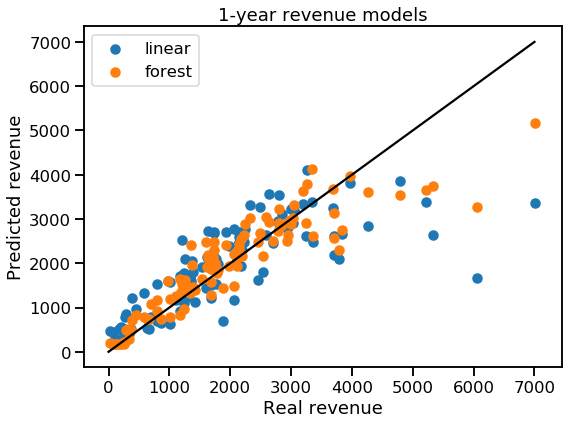

In [29]:
pl.figure(figsize=(8, 6))
pl.scatter(data_y, y_pred_lin, label='linear')
pl.scatter(data_y, y_pred_tree, label='forest')
pl.plot([0,7000], [0,7000], '-k')

pl.legend()
pl.xlabel('Real revenue')
pl.ylabel('Predicted revenue')
pl.title('1-year revenue models')
pl.tight_layout()
pl.savefig('ltrplots/model_comparison.png')

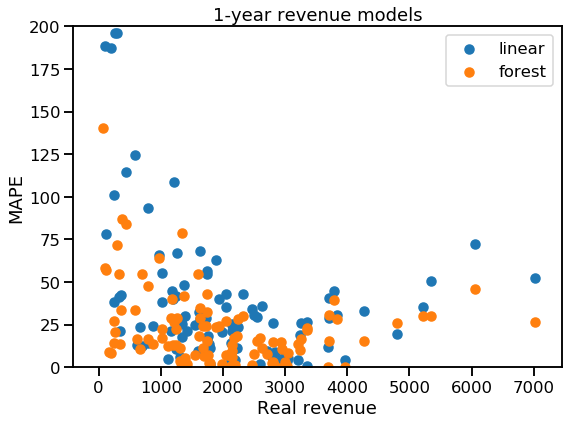

In [30]:
pl.figure(figsize=(8, 6))
pl.scatter(data_y, np.abs(data_y-y_pred_lin) / data_y * 100, label='linear')
pl.scatter(data_y, np.abs(data_y-y_pred_tree) / data_y * 100, label='forest')

pl.ylim([0, 200])
pl.legend()
pl.xlabel('Real revenue')
pl.ylabel('MAPE')
pl.title('1-year revenue models')
pl.tight_layout()
pl.savefig('ltrplots/model_comparison_mape.png')

## Check how the model performs on the test set

In [31]:
testdata = pd.read_csv('daily_cohorts_test.csv')

In [32]:
test_cohorts = testdata.groupby(['campaign_date', 'platform'])['day', 'cum_revenue'].max()
test_cohorts.reset_index(inplace=True)

/home/joris/Software/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [33]:
test_extra = data[data['campaign_date'].isin(test_cohorts['campaign_date'].unique())]

In [34]:
features_test = ['spend', 'installs',
'cum_revenue_3', 'cum_purchases_3', 'cum_new_payers_3', 'cum_iap_net_revenue_3', 'cum_ad_net_revenue_3',
'cum_revenue_7', 'cum_purchases_7', 'cum_new_payers_7', 'cum_iap_net_revenue_7', 'cum_ad_net_revenue_7']

In [35]:
test_extra = test_extra.groupby(['campaign_date', 'platform'])[features_test].max()
test_extra.reset_index(inplace=True)

In [36]:
test_data = pd.merge(test_cohorts, test_extra,  how='left', left_on=['campaign_date', 'platform'], right_on = ['campaign_date', 'platform'])

In [37]:
test_data.dropna(inplace=True)
platform_conversion = {'android': 0, 'ios': 1}
test_data['platform'] = test_data['platform'].apply(lambda x: platform_conversion[x])
test_data = process_data(test_data)
test_data

,campaign_date,platform,day,cum_revenue,spend,installs,cum_revenue_3,cum_purchases_3,cum_new_payers_3,cum_iap_net_revenue_3,cum_ad_net_revenue_3,cum_revenue_7,cum_purchases_7,cum_new_payers_7,cum_iap_net_revenue_7,cum_ad_net_revenue_7,cohort,cohort_day
0,2019-05-01,0,364,1848.743695,1551.659060,2604,312.145098,74.0,57.0,248.319416,63.825682,495.868242,103.0,78.0,391.611499,104.256743,2019-05-01,68
1,2019-05-01,1,364,587.866385,444.521603,423,61.613354,7.0,5.0,39.479810,22.133544,169.193760,13.0,8.0,127.183791,42.009969,2019-05-01,68
2,2019-05-02,0,364,1918.412511,1570.762175,2193,248.962014,67.0,48.0,194.534539,54.427475,470.782892,108.0,79.0,381.210939,89.571953,2019-05-02,69
3,2019-05-02,1,364,1637.166183,446.176278,410,105.402838,13.0,10.0,77.611061,27.791777,326.402333,24.0,19.0,278.697559,47.704774,2019-05-02,69
4,2019-05-03,0,364,2711.665322,1583.817297,2632,358.315257,89.0,68.0,290.546896,67.768361,533.076572,114.0,91.0,420.708914,112.367658,2019-05-03,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2019-06-27,1,364,8442.128843,3952.646672,1075,534.667421,65.0,56.0,421.993622,112.673799,894.743333,101.0,84.0,698.265979,196.477354,2019-06-27,125
116,2019-06-28,0,364,10263.950219,5959.547914,4787,957.443828,143.0,106.0,763.466423,193.977405,1926.419268,236.0,170.0,1621.483671,304.935597,2019-06-28,126
117,2019-06-28,1,364,7103.661785,4352.188057,1481,735.541563,88.0,68.0,607.739097,127.802466,1253.377365,124.0,97.0,1031.605083,221.772282,2019-06-28,126
118,2019-06-29,0,364,10655.450806,6521.550411,5188,1386.600392,221.0,173.0,1170.816099,215.784293,2430.503770,349.0,268.0,2079.874753,350.629017,2019-06-29,127


In [38]:
test_X_lr = preprocessor.transform(test_data[X_features])
test_X_rf = test_data[X_features_rf]
test_y = test_data[y_features]

print('Mean absolute error:')
print('Linear Model: ', metrics.mean_absolute_error(test_y, lr_model.predict(test_X_lr)))
print('Random Forest: ', metrics.mean_absolute_error(test_y, gs_model.predict(test_X_rf)))
print()

print('Mean absolute precentage error:')
print('Linear Model: ', mean_absolute_precentage_error(test_y, lr_model.predict(test_X_lr)))
print('Random Forest:: ', mean_absolute_precentage_error(test_y, gs_model.predict(test_X_rf)))

Mean absolute error:
Linear Model:  1230.8236984168889
Random Forest:  1461.927415664909

Mean absolute precentage error:
Linear Model:  34.27953354140142
Random Forest::  34.81597959189634


In [39]:
y_pred_lin = lr_model.predict(test_X_lr)
y_pred_tree = gs_model.predict(test_X_rf)

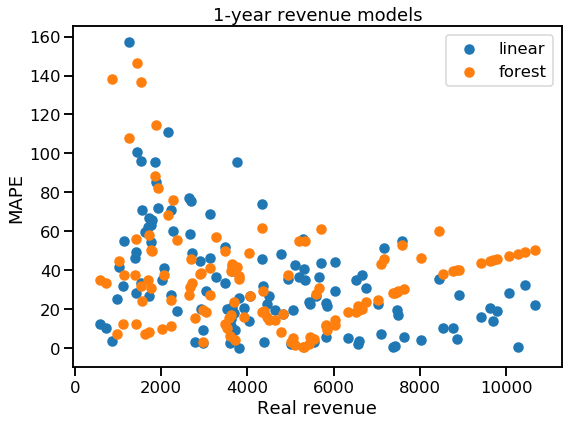

In [40]:
pl.figure(figsize=(8, 6))
pl.scatter(test_y, np.abs(test_y-y_pred_lin) / test_y * 100, label='linear')
pl.scatter(test_y, np.abs(test_y-y_pred_tree) / test_y * 100, label='forest')

pl.legend()
pl.xlabel('Real revenue')
pl.ylabel('MAPE')
pl.title('1-year revenue models')
pl.tight_layout()
pl.savefig('ltrplots/model_comparison_test_mape.png')